In [29]:
# _*_ coding: utf-8 _*_
import matplotlib.pyplot as plt
from keras.layers import Input,Dense,Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np

In [8]:
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 50

In [11]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim,activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [20]:
def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape=(batch_size,latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon
    
z = Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])

In [35]:
decoder_h = Dense(intermediate_dim,activation='relu')
decoder_mean = Dense(original_dim,activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [40]:
def vae_loss(x,x_decoded_mean):
    xent_loss = original_dim*objectives.binary_crossentropy(x,x_decoded_mean)
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
    return xent_loss + kl_loss

vae = Model(x,x_decoded_mean)
vae.compile(optimizer='adam',loss=vae_loss)

In [42]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

vae.fit(x_train,x_train,batch_size=batch_size,shuffle=True,epochs=epochs,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 50us/step - loss: 145.1581 - val_loss: 149.7066
Epoch 2/50
60000/60000 [==============================] - 3s 43us/step - loss: 145.0718 - val_loss: 149.5228
Epoch 3/50
60000/60000 [==============================] - 3s 43us/step - loss: 145.0262 - val_loss: 149.6437
Epoch 4/50
60000/60000 [==============================] - 3s 43us/step - loss: 144.9915 - val_loss: 149.6943
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 144.9136 - val_loss: 149.3740
Epoch 6/50
60000/60000 [==============================] - 3s 44us/step - loss: 144.9194 - val_loss: 149.6067
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 144.8206 - val_loss: 149.5982
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 144.8279 - val_loss: 149.6842
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss:

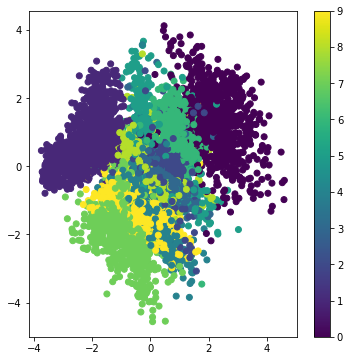

In [46]:
encoder = Model(x,z_mean)
x_test_encoded = encoder.predict(x_test,batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1],c=y_test)
plt.colorbar()
plt.show()

In [48]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input,_x_decoded_mean)

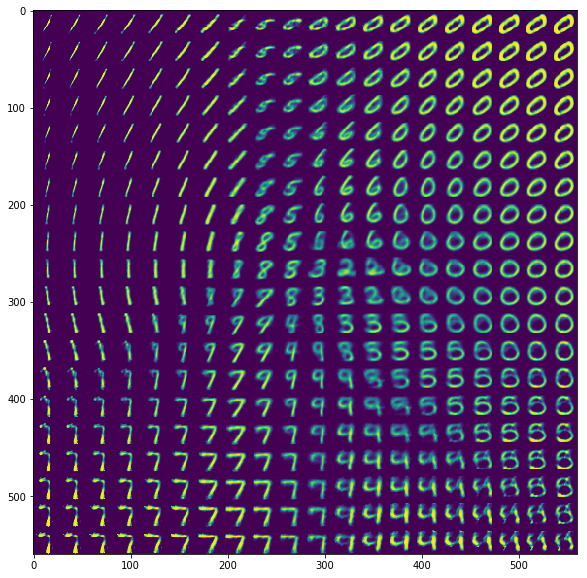

In [50]:
n = 20
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))
grid_x = np.linspace(-4,4,n)
grid_y = np.linspace(-4,4,n)

for i,xi in enumerate(grid_x):
    for j,yi in enumerate(grid_y):
        z_sample = np.array([[yi,xi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[(n - i - 1)*digit_size:(n-i)*digit_size,j*digit_size:(j+1)*digit_size] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()